In [4]:
import sys
sys.path.append("../lropy")

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import pandas as pd
import numpy as np
import seaborn as sb
import spiceypy as spice

from datetime import datetime, timedelta
from pathlib import Path

In [6]:
from lropy.analysis.spice_tools import as_et, as_utc, as_tdb, generate_lro_ephemeris
from lropy.analysis.io import load_simulation_results, load_all_simulation_results, pos_names, vel_names, acc_names, irr_names, panels_count_names
from lropy.analysis.plotting import format_plot, save_plot
from lropy.analysis.transform import spher2cart, cart2spher, align_vectors

# Effect of instantaneous reradiation

In [7]:
results_folder_rerad = Path("../results/instantaneous_reradiation_test-2023-07-17T22-55-48-1b290")
# metadata = load_all_simulation_results(results_folder, load_runs=False)
metadata_rerad, runs_rerad = load_all_simulation_results(results_folder_rerad, load_runs=True, do_tf=True)

100%|██████████| 3/3 [00:56<00:00, 18.88s/it]


In [8]:
metadata_rerad

,id,hostname,start_timestamp,save_dir,simulation_start,target_type,with_instantaneous_reradiation,use_occultation,use_solar_radiation,use_moon_radiation,paneling_moon,number_of_panels_moon,number_of_panels_per_ring_moon,albedo_distribution_moon,thermal_type_moon,simulation_duration,step_size,walltime_duration
1,994a0,unknown,2023-07-17T22:55:48.933960,/home/dominik/dev/hpb-project/results/instanta...,2010 SEP 26 06:00:00,Paneled,False,True,True,True,Dynamic,0,"[6, 12]",Constant,AngleBased,13560,10,317.060264
2,691e6,unknown,2023-07-17T22:55:48.934014,/home/dominik/dev/hpb-project/results/instanta...,2010 SEP 26 06:00:00,Paneled,True,True,True,True,Dynamic,0,"[6, 12]",Constant,AngleBased,13560,10,316.287972
3,17dca,unknown,2023-07-17T22:55:48.934051,/home/dominik/dev/hpb-project/results/instanta...,2010 SEP 26 06:00:00,Paneled,False,True,False,False,,0,[],,,13560,10,278.42799


In [9]:
df_with_rerad = runs_rerad[metadata_rerad[metadata_rerad["use_moon_radiation"] & metadata_rerad["with_instantaneous_reradiation"]].index[0]]
df_without_rerad = runs_rerad[metadata_rerad[metadata_rerad["use_moon_radiation"] & ~metadata_rerad["with_instantaneous_reradiation"]].index[0]]

In [10]:
def plot_rp(source):
    fig, axs = plt.subplots(3, figsize=(12, 6))

    for comp, ax in zip(["radial", "along", "cross"], axs):
        ax.set_title(comp)
        ax.plot(df_with_rerad.index, df_with_rerad[f"acc_rp_{source}_{comp}"], label="With instantaneous reradiation")
        ax.plot(df_without_rerad.index, df_without_rerad[f"acc_rp_{source}_{comp}"], label="Without instantaneous reradiation")

    axs[0].legend()

    format_plot()

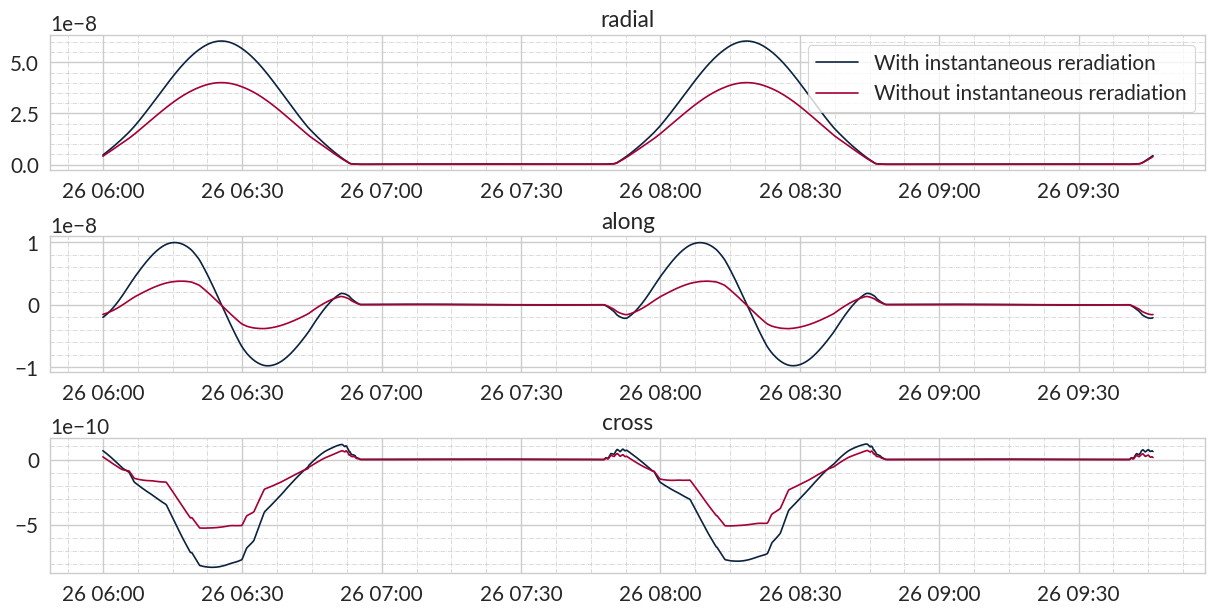

In [11]:
plot_rp("moon")

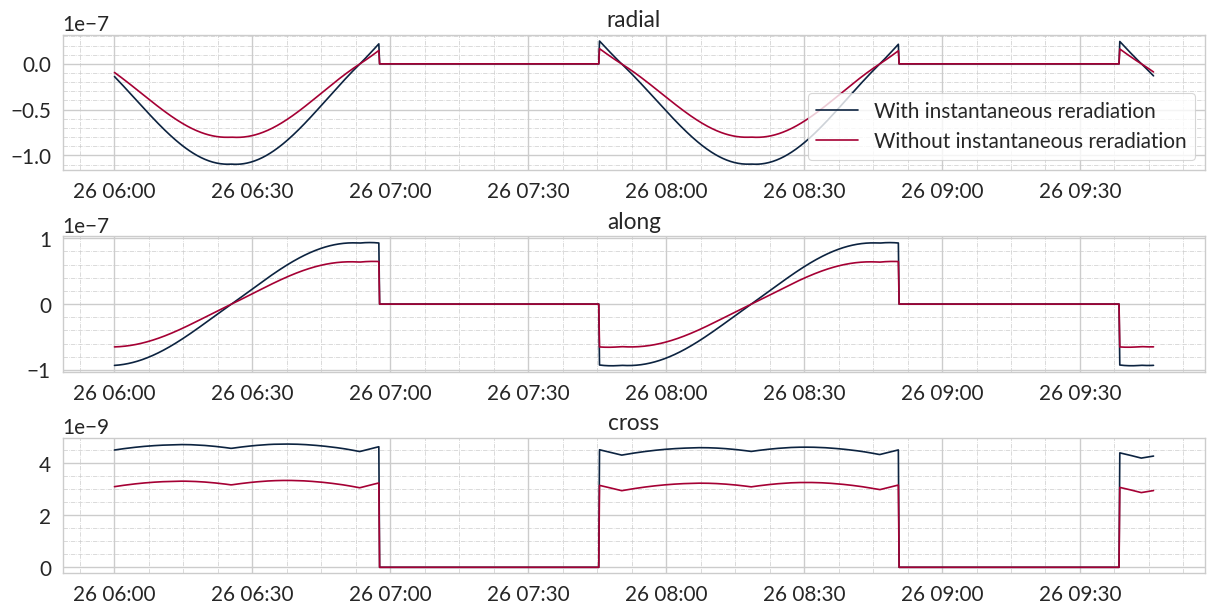

In [12]:
plot_rp("sun")

Shape of both is actually different, i.e. instantaneous reradiation is not simply a factor.

# Relative contribution of albedo and thermal

In [13]:
results_folder_contribs = Path("../results/albedo_thermal_test-2023-07-18T13-45-27-c9706")
# metadata = load_all_simulation_results(results_folder, load_runs=False)
metadata_contribs, runs_contribs = load_all_simulation_results(results_folder_contribs, load_runs=True, do_tf=True)

100%|██████████| 6/6 [01:32<00:00, 15.48s/it]


In [14]:
metadata_contribs

,id,hostname,start_timestamp,save_dir,simulation_start,target_type,with_instantaneous_reradiation,use_occultation,use_solar_radiation,use_moon_radiation,paneling_moon,number_of_panels_moon,number_of_panels_per_ring_moon,albedo_distribution_moon,thermal_type_moon,simulation_duration,step_size,walltime_duration
1,5c648,eudoxos,2023-07-18T13:45:27.313019,/home2/dominik/dev/lropy/results/albedo_therma...,2010 SEP 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12]",Constant,NoThermal,13560,10,151.075854
2,ba64f,eudoxos,2023-07-18T13:45:27.313042,/home2/dominik/dev/lropy/results/albedo_therma...,2010 SEP 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12]",NoAlbedo,AngleBased,13560,10,152.530898
3,d8330,eudoxos,2023-07-18T13:45:27.313070,/home2/dominik/dev/lropy/results/albedo_therma...,2010 SEP 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12]",DLAM1,AngleBased,13560,10,177.160113
4,3c193,eudoxos,2023-07-18T13:45:27.313089,/home2/dominik/dev/lropy/results/albedo_therma...,2010 SEP 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12]",Constant,AngleBased,13560,10,154.036236
5,e95dc,eudoxos,2023-07-18T13:45:27.313103,/home2/dominik/dev/lropy/results/albedo_therma...,2010 SEP 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12]",DLAM1,NoThermal,13560,10,174.085129
6,fb845,eudoxos,2023-07-18T13:45:27.313115,/home2/dominik/dev/lropy/results/albedo_therma...,2010 SEP 26 06:00:00,Cannonball,False,True,False,False,,0,[],,,13560,10,144.559294


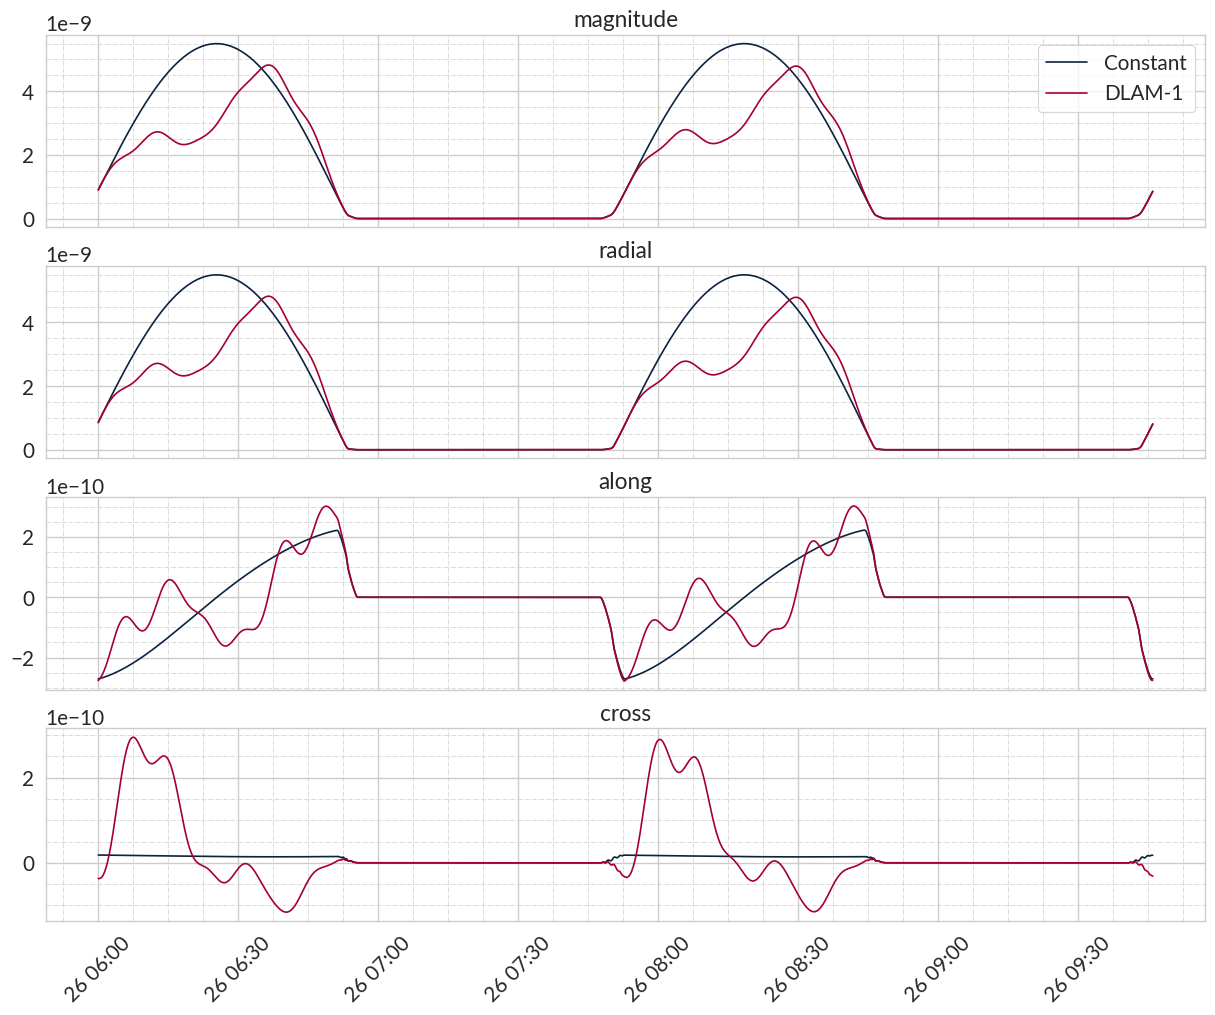

In [15]:
def compare_constant_dlam():
    df_constant_dlam = runs_contribs[metadata_contribs[(metadata_contribs["albedo_distribution_moon"] == "DLAM1") & (metadata_contribs["thermal_type_moon"] == "NoThermal")].index[0]]
    df_constant_constant = runs_contribs[metadata_contribs[(metadata_contribs["albedo_distribution_moon"] == "Constant") & (metadata_contribs["thermal_type_moon"] == "NoThermal")].index[0]]

    fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex="all")
    ax_mag, ax_radial, ax_along, ax_cross = axs

    for df, label in zip([df_constant_constant, df_constant_dlam], ["Constant", "DLAM-1"]):
        ax_mag.plot(df.index, df["acc_rp_moon"], label=label)
        ax_radial.plot(df.index, df["acc_rp_moon_radial"])
        ax_along.plot(df.index, df["acc_rp_moon_along"])
        ax_cross.plot(df.index, df["acc_rp_moon_cross"])

    ax_mag.set_title("magnitude")
    ax_radial.set_title("radial")
    ax_along.set_title("along")
    ax_cross.set_title("cross")
    ax_mag.legend()

    for ax in axs.flat:
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()

compare_constant_dlam()

## Delayed vs angle-based thermal radiation